In [27]:
import config # .gitignore
import pandas as pd
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

auth_manager = SpotifyClientCredentials(client_id=config.SPOTIPY_CLIENT_ID, client_secret=config.SPOTIPY_CLIENT_SECRET)
sp = spotipy.Spotify(auth_manager=auth_manager)

happy_playlists = ['https://open.spotify.com/playlist/37i9dQZF1EIerWLYY5lG2u','https://open.spotify.com/playlist/37i9dQZF1EIcLfJYjuP7bx','https://open.spotify.com/playlist/37i9dQZF1EVJSvZp5AOML2','https://open.spotify.com/playlist/37i9dQZF1EIgG2NEOhqsD7','https://open.spotify.com/playlist/37i9dQZF1DXdPec7aLTmlC']
sad_playlists = ['https://open.spotify.com/playlist/37i9dQZF1EIdChYeHNDfK5','https://open.spotify.com/playlist/37i9dQZF1DWSqBruwoIXkA','https://open.spotify.com/playlist/37i9dQZF1EIg6gLNLe52Bd','https://open.spotify.com/playlist/37i9dQZF1DWW2hj3ZtMbuO','https://open.spotify.com/playlist/37i9dQZF1DWVV27DiNWxkR']
features = ['danceability','energy','key','loudness','mode','speechiness','acousticness','instrumentalness','liveness','valence','tempo','time_signature']

def get_attributes(playlists, features):
    # get attributes of songs in playlist
    # playlist_link: list of spotify playlist links
    # features: list of features to get
    old = []
    for i in playlists:
        playlist_link = i
        playlist_URI = playlist_link.split("/")[-1].split("?")[0]
        track_uris = [x[ "track"]["uri"] for x in sp.playlist_tracks(playlist_URI)["items"]]
        new = sp.audio_features(track_uris)
        new = [x for x in new if x is not None]
        old = old+new
        df = pd.DataFrame(old)[features]
    return df

happy = get_attributes(happy_playlists, features)
sad = get_attributes(sad_playlists, features)

happy['label'] = '1'
sad['label'] = '0'


In [28]:
merged = pd.concat([happy, sad])
training = merged.sample(frac=0.5, random_state=25)
testing = merged.drop(training.index)

X_train = training.drop('label', axis=1)
Y_train = training['label']
X_test = testing.drop('label', axis=1)
Y_test = testing['label']


In [29]:
# lightGBM decision tree
import lightgbm as lgb

clf = lgb.LGBMClassifier()
clf.fit(X_train, Y_train)
y_pred=clf.predict(X_test)

# Accuracy
clf.score(X_test, Y_test)


0.9108910891089109

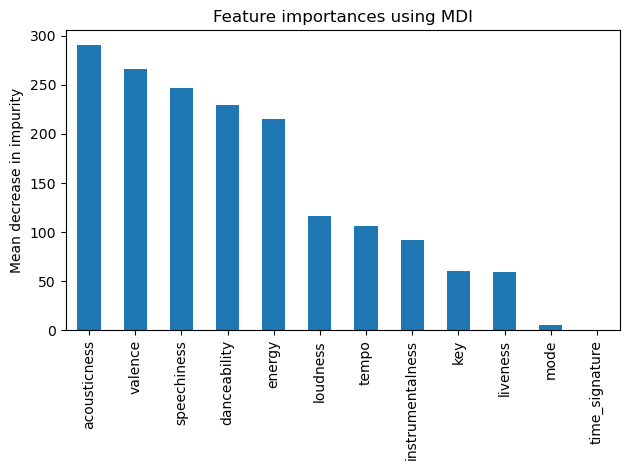

In [30]:
import matplotlib.pyplot as plt
# feature importance
importance = clf.feature_importances_

dt_importances = pd.Series(importance, index=X_train.columns).sort_values(ascending=False)

fig, ax = plt.subplots()
dt_importances.plot.bar(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()